In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyksc import ksc

In [2]:
FILENAME='/home/wagner/GitHub/curva_crescimento/dataset/dataset.csv'

In [3]:
# load dataset
df = pd.read_csv(FILENAME, usecols=['Commit', 'Date', 'Project', 
                                    'blank', 'code', 'comment', 
                                    'filename', 'language'])

# removes dirt from the Date column 
df['Date'] = df.Date.apply(lambda date: date.replace('.csv', ''))

/home/wagner/Virtualizations/labes/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# convert column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# sort column
df = df.sort_values(by='Date')

In [5]:
# filter only the languages that are being used
df = df.loc[(df['language']  == 'C') |
              (df['language'] == 'C++') |
              (df['language'] == 'C#') |
              (df['language'] == 'Clojure') |
              (df['language'] == 'CoffeeScript') |
              (df['language'] == 'Go') |
              (df['language'] == 'Haskell') |
              (df['language'] == 'Java') |
              (df['language'] == 'JavaScript') |
              (df['language'] == 'Kotlin') |
              (df['language'] == 'Lua') |
              (df['language'] == 'Objective C') |
              (df['language'] == 'PHP') |
              (df['language'] == 'Python') |
              (df['language'] == 'Ruby') |
              (df['language'] == 'Rust') |
              (df['language'] == 'Scala') |
              (df['language'] == 'Swift') |
              (df['language'] == 'TypeScript') |
              (df['language'] == 'Elixir')]

In [6]:
def file_unique(dfx):
    """
    Cria uma lista com arquivos unicos e remove os arquivos repetidos
    
    Parameters:
    ----------
    object dfx: recebe um dataset
    
    Return:
    -------
    list files: lista com os arquivos unicos
    """
    
    files_list = dfx.filename.tolist()

    files = []

    for i in files_list:
        if(i not in files):
            files.append(i)
    
    return(files)

In [7]:
# Filtra o dataframe para apenas arquivos acima do limiar
dfx = df.loc[df['code'] >= 13196]


unique_files = file_unique(dfx)

In [8]:
# print("Quantidade de arquivos unicos: ", len(unique_files))

In [9]:
def create_dataframe(df, unique_files):
    '''
    Cria um dataframe para cada arquivo unico e adiciona numa lista. 
    
    Parameters:
    -----------
    object df: Dataset
    list unique_files: Lista com os arquivos unicos
    
    Return:
    -------
    list dfs: Uma lista com varios dataframes
    '''
    
    dfs = []
    
    for path in unique_files:
         dfs.append(df.loc[df['filename'] == path])
    
    return(dfs)

In [10]:
# Torna float a coluna code
dfx['code'] = dfx.code.apply(lambda code: float(code))

/home/wagner/Virtualizations/labes/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
dfs = create_dataframe(dfx, unique_files)

In [12]:
"""
d = {'Date': frame.Date.tolist(), 'Code': frame.code.tolist()}
d['Code'].insert(0,0)
d['Date'].insert(0,d['Date'][0])

dfx2 = pd.DataFrame(data=d)

dfx2['Code'] = dfx2.Code.apply(lambda code: float(code))
"""

"\nd = {'Date': frame.Date.tolist(), 'Code': frame.code.tolist()}\nd['Code'].insert(0,0)\nd['Date'].insert(0,d['Date'][0])\n\ndfx2 = pd.DataFrame(data=d)\n\ndfx2['Code'] = dfx2.Code.apply(lambda code: float(code))\n"

In [13]:
def create_series(dfs):
    '''
    Percorre cada dataframe da lista e adiciona o LOC
    e os anos de cada um em uma lista.
    
    Parameters:
    -----------
    object dfs: Lista com dataframes
    
    Return:
    -------
    list tm_series: Lista com o LOC de cada arquivo
    list years: Lista com os anos de cada arquivo
    '''
    
    time_series = [] 
    years = [] 
    
    for df in dfs:
        time_series.append(df.code.tolist())
        years.append(df.Date.dt.year.tolist())
        
    return(time_series, years)


loc_list, years = create_series(dfs)

In [14]:
import statistics as stacs

# Cria a media e a mediana

value_sum = 0
value_list = []

for i in tm_series:
    value_sum+=len(i)
    value_list.append(len(i))
    
value_list = sorted(value_list)

min_value = value_sum/len(tm_series)

print("Media de LOC:", value_sum/len(loc_list))
print("Mediana de LOC:", stacs.median(value_list))

('Media de LOC:', 17)
('Mediana de LOC:', 6.0)


In [15]:
# Usado para deixar as listas com o mesmo tamanho 

def size_series(loc_list, min_value):
    
    """
    Verifica as listas que possuem o tamanho menor que o valor minimo
    e remove, apos isso deixa todas as listas com o mesmo tamanho
    
    Parameters:
    -----------
    list loc_list: Lista com todos os LOC dos arquivos
    int min_value: Valor minimo para tamanho das listas
    
    Return:
    -------
    list loc_list: Nova lista de LOC
    int min_value: Novo valor minimo
    
    """
    
    flag = False

    while(flag != True):
        
        for i in range(len(loc_list)):
            
            if(len(loc_list[i]) < min_value):
                loc_list.pop(i)
                break

            for j in range(len(loc_list[i])):
                if(j >= min_value):
                    loc_list[i].pop(j)
                    
                    break
                    
        for serie in loc_list:
            if(len(serie) == min_value):
                flag = True
            else:
                flag = False
                break
        
    # para todas séries iniciarem em zero, como sendo a criacao do arquivo
    for serie in loc_list:
        serie.insert(0,0)
        
    return(loc_list, min_value+1)

In [16]:
new_loc_list, new_min_value = size_series(tm_series, min_value)

In [18]:
def create_year_serie(min_value, years):
    """
    Cria uma lista com a quantidade de anos, apos isso adiciona
    novamente cada ano ate a lista ter o tamanho necessario
    
    Parameters:
    -----------
    int min_value: Valor minimo para tamanho da lista
    list years: Lista de anos de cada arquivo
    
    Return:
    -------
    list new_year: Lista de anos conforme o min value
    
    """
    
    new_year = [] 

    for year in years:
        for i in year:
            if i not in new_year:
                new_year.append(i)

    cont = 0 
    while(len(new_year) < min_value):
        new_year.append(new_year[cont])
        cont+=1

    new_year = sorted(new_year)
    
    return(new_year)

In [19]:
# para gerar esses plots deve ser em float o loc
tm_series = np.array(new_loc_list) #Cria uma matriz com os valores de LOC

clusters_by_time_series = {}

centroids, assign, best_shift, cent_dists = ksc.ksc(tm_series, 3) # inicia o algoritmo com 3 clusters


In [20]:
if assign is not None:
    for series, cluster in zip(tm_series, assign):
        if cluster in clusters_by_time_series.keys():
            clusters_by_time_series[cluster].append(series)
        else:
            clusters_by_time_series[cluster] = [series]

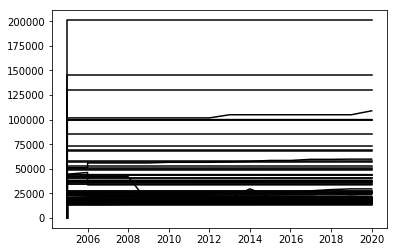

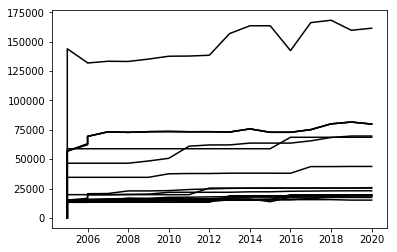

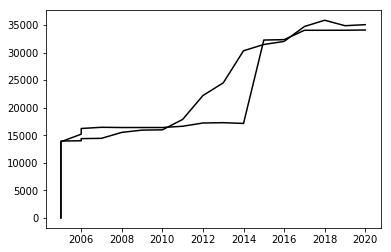

In [21]:
weeks = None 

for cluster in clusters_by_time_series.keys():
    figure = plt.figure()

    for project_time_series in clusters_by_time_series[cluster]:
        if weeks is None:
            weeks = [-i for i in range(len(project_time_series) - 1, -1, -1)]

        project_time_series = [0 if i == 0.1 else int(i) for i in project_time_series]
        
        years_d = create_year_serie(len(project_time_series), years)

        plt.plot(years_d, project_time_series, color='black')
        
        figure.savefig('curva_crescimento.png', bbox_inches='tight', format='png', dpi=1000)

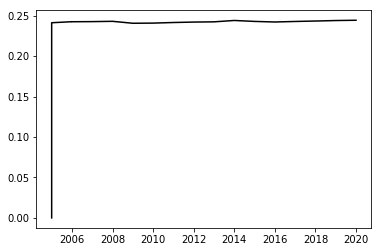

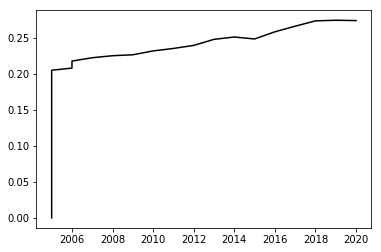

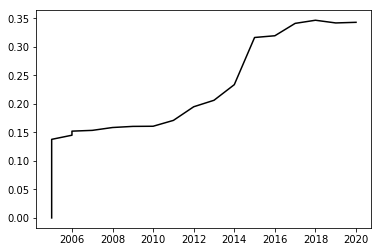

In [22]:

for cluster, centroid in zip(range(0, 3), centroids):
    growth_rate = centroid[0] + centroid[-1] * 100
    #report_file.write(str(cluster) + ': ' + str(centroid) + ' (Growth:' + str("{0:.2f}".format(growth_rate)) + ')\n')

    if weeks is None:
        weeks = [-i for i in range(len(centroid) - 1, -1, -1)]

    figure = plt.figure()
    plt.plot(years_d, centroid, color='black')
